# Import

In [1]:
import pandas as pd
import numpy as np

# Input and Cleaning

In [2]:
# We will analyse the renamed "dmlz_assay" csv file in this notebook
DH_ROOT = '../data/ptfi_2/dh_and_bm_data/drillholes/'

assay = pd.read_csv(DH_ROOT + 'assay.csv')
bf = pd.read_csv(DH_ROOT + 'bulk_factor.csv')
bulk = pd.read_csv(DH_ROOT + 'bulk.csv')
collar = pd.read_csv(DH_ROOT + 'collar.csv', index_col=0)
survey = pd.read_csv(DH_ROOT + 'survey.csv')

---

Knowing what we know from the analysis of these dataframes, we want to convert them to drillhole objects with certain properties and information. It should ease the process of organising and eventually calculating individual heterogeneity.

Before removing any data, we just want to group by drillhole to see how we would go about combining/merging the data together. We can first create a grouping of drillholes by using the collar dataset.

---

In [3]:
collar.head()

,EAST,NORTH,ELEV,TD,AZI,INCLIN,ENDATE,COMPST,PROJ,CLIENT,CORING
HOLEID,,,,,,,,,,,
DZ30-01GT-90,737277.996,9548950.851,3004.678,438.6,40.210,-48.439,12-Sep-2017,C,EESS,COWA,DD
DZ30-01SM-04,737664.303,9548767.564,3080.914,250.0,340.000,-44.920,22-Jan-2022,CG,EESS,COWA,DD
DZ30-03SM-02,736821.780,9549151.749,3092.879,550.0,354.712,-24.930,5-Aug-2022,CG,EESS,COWA,DD
DZ30-N0F-01,737494.450,9549029.078,3076.972,490.0,346.610,-64.217,18-Apr-2019,C,EESS,COWA,DD
DZ31-EJ4-917,737225.946,9549221.306,3104.496,397.2,103.520,-63.089,19-Sep-2020,C,EESS,COWA,DD


# Grouping

## Testing

---

We can try to group the data in other datasets using the 'HOLEID' column in this dataframe as every dataframe has a 'HOLEID' column. We'll try it first with one drillhole. The second entry was selected as the first one doesn't seem to contain much information.

---

In [4]:
dh = collar.iloc[1, 0]
dh_collar = collar.iloc[1]
collar.iloc[1]

EAST       737664.303
NORTH     9548767.564
ELEV         3080.914
TD              250.0
AZI             340.0
INCLIN         -44.92
ENDATE    22-Jan-2022
COMPST             CG
PROJ             EESS
CLIENT           COWA
CORING             DD
Name: DZ30-01SM-04, dtype: object

In [5]:
dh_assay = assay.query('HOLEID == @dh').iloc[:, 1:].sort_values(by=['FROM']).reset_index(drop=True)
dh_assay

,FROM,TO,INTLEN,SAMPID,CU,AU,AG


In [6]:
dh_bf = bf.query('HOLEID == @dh').iloc[:, 1:].sort_values(by=['FROM']).reset_index(drop=True)
dh_bf

,FROM,TO,INTLEN,BITSIZ,RECOV,BULK_F


In [7]:
dh_bf.RECOV.unique()

array([], dtype=float64)

In [8]:
dh_bulk = bulk.query('HOLEID == @dh').iloc[:, 1:].sort_values(by=['FROM']).reset_index(drop=True)
dh_bulk

,FROM,TO,INTLEN,DENSTY


In [9]:
dh_survey = survey.query('HOLEID == @dh').iloc[:, 1:].sort_values(by=['DEPTH']).reset_index(drop=True)
dh_survey

,DEPTH,AZIM,DIP,METD


---

We can now try put all of this information into a DrillHole object.

---

# Drillhole Object

In [10]:
def tangent_desurvey(x0, y0, z0, depths, azims, dips):
    """Brief description of basic tangent desurveying https://www.seequent.com/the-dark-art-of-drillhole-desurveying/

    Args:
        x0 (_type_): Collar Easting
        y0 (_type_): Collar Northing
        z0 (_type_): Collar Elevation
        depths (_type_): a list of depths
        azims (_type_): a list of azimuths
        dips (_type_): a list of dips
    """
    xs, ys, zs = [], [], []
    
    xs.append(x0)
    ys.append(y0)
    zs.append(z0)
    
    i = 1
    
    while i < len(depths):
        dist = depths[i] - depths[i - 1]
        azi = azims[i - 1]
        dip = dips[i - 1]
        
        dx = dist * np.sin(np.deg2rad(azi)) * np.cos(np.deg2rad(dip))
        dy = dist * np.cos(np.deg2rad(azi)) * np.cos(np.deg2rad(dip))
        dz = dist * np.sin(np.deg2rad(dip))
        
        xs.append(xs[-1] + dx)
        ys.append(ys[-1] + dy)
        zs.append(zs[-1] + dz)
        
        i += 1
        
    return pd.DataFrame({'EAST': xs, 'NORTH': ys, 'ELEV': zs})
    
    
    

class Drillhole:
    def __init__(self, id, assay, bf, bulk, collar, survey):
        self._id = id
        self._assay = assay
        self._bf = bf
        self._bulk = bulk
        self._collar = collar
        self._survey = survey
        
    def set_desurvey(self, desurvey):
        self._desurvey = desurvey
        
drillhole = Drillhole(dh, dh_assay, dh_bf, dh_bulk, dh_collar, dh_survey)

In [11]:
drillhole._collar

EAST       737664.303
NORTH     9548767.564
ELEV         3080.914
TD              250.0
AZI             340.0
INCLIN         -44.92
ENDATE    22-Jan-2022
COMPST             CG
PROJ             EESS
CLIENT           COWA
CORING             DD
Name: DZ30-01SM-04, dtype: object

---

We can now retreive the relevant information from a DrillHole object, however, it might be possible to combine some of the data together as well.

We can see that collar contains x, y, z data (`EAST`, `NORTH`, and `ELEV`), which can be combined with survey's `DEPTH`, `AZIM`, and `DIP`, along with the survey method to determine positional data at a given depth.

This depth data, in the form of `FROM`, and `TO` is found in the remaining data. 

---

# Creating Drillholes

In [12]:
drillholes = {}

drillhole_ids = collar.index.to_list()
for id in drillhole_ids:
    dh_assay = assay.query('HOLEID == @id').iloc[:, 1:].sort_values(by=['FROM']).reset_index(drop=True)
    dh_bf = bf.query('HOLEID == @id').iloc[:, 1:].sort_values(by=['FROM']).reset_index(drop=True)
    dh_bulk = bulk.query('HOLEID == @id').iloc[:, 1:].sort_values(by=['FROM']).reset_index(drop=True)
    dh_collar = collar.loc[[id]].reset_index(drop=True).squeeze()
    dh_survey = survey.query('HOLEID == @id').iloc[:, 1:].sort_values(by=['DEPTH']).reset_index(drop=True)
    
    drillholes[id] = Drillhole(
        id, 
        dh_assay, 
        dh_bf, 
        dh_bulk, 
        dh_collar, 
        dh_survey
    )
    
    dh_desurvey = tangent_desurvey(
        dh_collar['EAST'], 
        dh_collar['NORTH'], 
        dh_collar['ELEV'], 
        dh_survey['DEPTH'], 
        dh_survey['AZIM'], 
        dh_survey['DIP']
    )
    
    drillholes[id].set_desurvey(dh_desurvey)

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import ConvexHull

In [24]:
BM_ROOT = '../data/ptfi_2/dh_and_bm_data/DMLZ_Block_Model/'

block_model = pd.read_csv(BM_ROOT + 'block_model.csv', index_col=0)

filtered_block_model = block_model.query('cu > 0.001')
pts = filtered_block_model.iloc[:, 0:3].to_numpy()

hull = ConvexHull(pts)

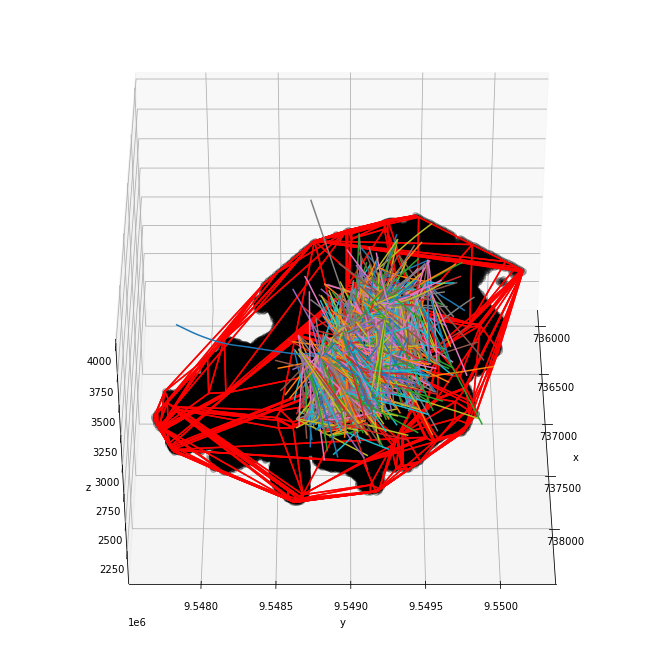

In [31]:
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.axes(projection='3d')

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko", alpha=0.2)

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

for id, drillhole in drillholes.items():
    desurvey = drillhole._desurvey
    ax.plot(desurvey['EAST'], desurvey['NORTH'], desurvey['ELEV'])
    
ax.azim = 0
ax.elev = 40

# Create axis labels
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


In [16]:
dhid = 'DZ30-03SM-02'

drillholes[dhid]._collar

EAST        736821.78
NORTH     9549151.749
ELEV         3092.879
TD              550.0
AZI           354.712
INCLIN         -24.93
ENDATE     5-Aug-2022
COMPST             CG
PROJ             EESS
CLIENT           COWA
CORING             DD
Name: 0, dtype: object

In [17]:
drillholes[dhid]._survey

,DEPTH,AZIM,DIP,METD
0,0.0,354.71,-24.93,SPRINT IQ
1,3.0,354.65,-24.97,SPRINT IQ
2,6.0,354.63,-25.00,SPRINT IQ
3,9.0,354.61,-25.02,SPRINT IQ
4,12.0,354.63,-25.04,SPRINT IQ
...,...,...,...,...
180,540.0,358.17,-26.44,PROJECTED
181,543.0,358.17,-26.44,PROJECTED
182,546.0,358.17,-26.44,PROJECTED
183,549.0,358.17,-26.44,PROJECTED


# Other

<AxesSubplot:>

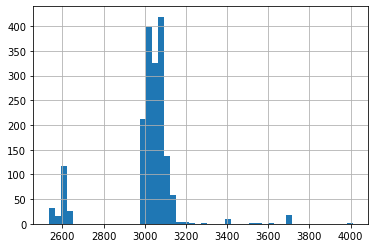

In [18]:
collar['ELEV'].hist(bins=50)